Import necessary **modules**:

In [1]:
%matplotlib inline
import os
import artm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
from datetime import datetime
from tree_sitter import Language, Parser
from glob import glob
from collections import Counter
from operator import itemgetter
from typing import List, Tuple

Load the languages into the **Language** objects:

In [2]:
JA_LANGUAGE = Language('../../tree-sitter/build/my-languages.so', 'java')

Create the Java **parser**:

In [3]:
parser = Parser()
parser.set_language(JA_LANGUAGE)

Create a list of all **files of interest**:

In [4]:
dataset = 'intellij-community'
starting_year = 2015
ending_year = 2020
list_of_files = {}
for year in range(starting_year, ending_year + 1):
    list_of_files[year] = [y for x in os.walk('data/' + dataset + '-' + str(year)) for y in glob(os.path.join(x[0], '*.java'))]

Define a function to **parse a file**: open a file, turn its content into bytes, parse it with a parser, traverse the tree and get all the identifiers out, count the repeated ones, format the obtained list in the form *token:amount* to be written to an intermediate file:

In [5]:
def ParseFile(file):
    with open(file, 'r') as fin:
        code = bytes(fin.read(), 'utf-8')
    tree = parser.parse(code)
    root = tree.root_node
    identifiers = []
    def addChildrenNodes(Node):
        for child in Node.children:
            if (child.type == 'identifier') or (child.type == 'type_identifier'):
                identifiers.append(code[child.start_byte:child.end_byte].decode('utf-8'))
            if len(child.children) != 0:
                addChildrenNodes(child)
    addChildrenNodes(root)
    sorted_identifiers = sorted(Counter(identifiers).items(), key = itemgetter(1), reverse=True)
    formatted_identifiers = []
    for identifier in sorted_identifiers:
        if identifier[0].rstrip() != '':
            formatted_identifiers.append(identifier[0].rstrip() + ':' + str(identifier[1]).rstrip())
    return(formatted_identifiers)

Parse all the files, store the data in a **temporary file**.

In [6]:
start_time = datetime.now()
indexes = {}
with open('data/' + dataset + '_tokens_of_files.txt', 'w+') as fout:
    count_nonempty_files = 0
    for year in range(starting_year, ending_year + 1):
        starting_index = count_nonempty_files + 1
        for file in tqdm(list_of_files[year]):
            if os.path.isfile(file) == True:
                try:
                    tokens_list = ParseFile(file)
                    if (len(tokens_list) != 0) and ('\n' not in ','.join(tokens_list)):
                        count_nonempty_files = count_nonempty_files + 1
                        fout.write(str(count_nonempty_files) + ';' + file + ';' + ','.join(tokens_list) + '\n')
                except UnicodeDecodeError:
                    continue
        ending_index = count_nonempty_files
        indexes[year] = [starting_index, ending_index]
print('Duration: {}'.format(datetime.now() - start_time))

100%|██████████| 64326/64326 [01:03<00:00, 1008.36it/s]

Duration: 0:05:33.726509


Reformat the temporary file into the **UCI bag-of-words format** for topic modeling:

In [7]:
start_time = datetime.now()
number_of_documents = 0
number_of_nnz = 0
set_of_tokens = set()
with open('data/' + dataset + '_tokens_of_files.txt', 'r') as fin:
    for line in fin:
        number_of_documents = number_of_documents + 1
        for token in line.rstrip().split(';')[2].split(','):
            number_of_nnz = number_of_nnz + 1
            set_of_tokens.add(token.split(':')[0])
            if token.split(':')[0] == "":
                print(line)
number_of_tokens = len(set_of_tokens)
print('Number of documents:', number_of_documents)
print('Number of tokens:', number_of_tokens)
print('Number of NNZ triples:', number_of_nnz)
sorted_list_of_tokens = sorted(list(set_of_tokens))
sorted_dictionary_of_tokens = {}

with open('data/vocab.' + dataset + '.txt', 'w+') as fout:
    for index in range(len(sorted_list_of_tokens)):
        sorted_dictionary_of_tokens[sorted_list_of_tokens[index]] = index + 1
        fout.write(sorted_list_of_tokens[index] + '\n')
        
with open('data/' + dataset + '_tokens_of_files.txt', 'r') as fin, open('data/docword.' + dataset + '.txt', 'w+') as fout:
    fout.write(str(number_of_documents) + '\n' + str(number_of_tokens) + '\n' + str(number_of_nnz) + '\n')
    for line in fin:
        file_tokens = line.rstrip().split(';')[2].split(',')
        file_tokens_separated = []
        file_tokens_separated_numbered = []
        for entry in file_tokens:
            file_tokens_separated.append(entry.split(':'))
        for entry in file_tokens_separated:
            file_tokens_separated_numbered.append([sorted_dictionary_of_tokens[entry[0]], int(entry[1])])
        file_tokens_separated_numbered = sorted(file_tokens_separated_numbered, key=itemgetter(0), reverse=False)
        for entry in file_tokens_separated_numbered:
            fout.write(str(line.split(';')[0]) + ' ' + str(entry[0]) + ' ' + str(entry[1]) + '\n')
print('Duration: {}'.format(datetime.now() - start_time))

Number of documents: 329982
Number of tokens: 375028
Number of NNZ triples: 15359198
Duration: 0:01:17.257954


Create **batches** and the **dictionary**:

In [8]:
start_time = datetime.now()
batch_vectorizer = artm.BatchVectorizer(data_path='data/', data_format='bow_uci',
                                        collection_name=dataset, target_folder='data/' + dataset + '_batches/')
dictionary = batch_vectorizer.dictionary
print('Duration: {}'.format(datetime.now() - start_time))

Duration: 0:00:40.442155


Create the **model**.

In [9]:
topic_names = ['topic_{}'.format(i) for i in range(100)]

model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True,
                         scores=[artm.PerplexityScore(name='PerplexityScore',
                                                      dictionary=dictionary),
                                 artm.SparsityPhiScore(name='SparsityPhiScore'),
                                 artm.SparsityThetaScore(name='SparsityThetaScore'),
                                 artm.TopicKernelScore(name='TopicKernelScore',
                                                       probability_mass_threshold=0.3),
                                 artm.TopTokensScore(name='TopTokensScore', num_tokens=15)],
                         regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                         tau=-0.15),
                                       artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
                                       artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5)])

**Train** the model.

In [10]:
start_time = datetime.now()

model_artm.num_document_passes = 1
model_artm.initialize(dictionary=dictionary)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

print('Duration: {}'.format(datetime.now() - start_time))

Duration: 0:13:01.070516


Get various **measures** for the model:

Sparsity Phi: 0.988
Sparsity Theta: 0.671
Kernel contrast: 0.920
Kernel purity: 0.789
Perplexity: 1033.844


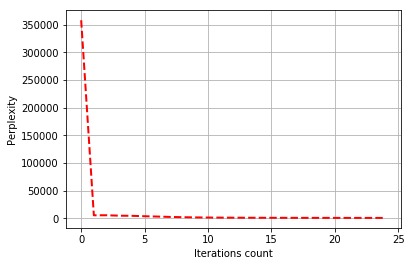

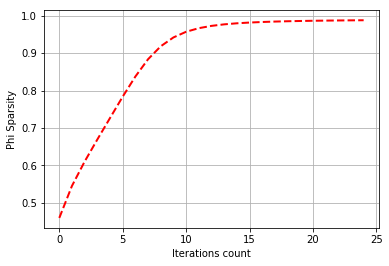

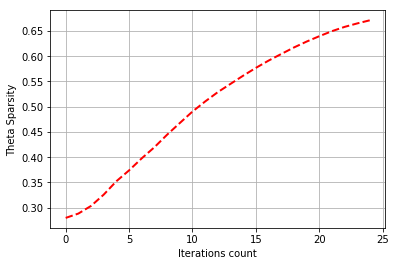

In [11]:
def print_measures(model):
    print ('Sparsity Phi: {0:.3f}'.format(
        model.score_tracker['SparsityPhiScore'].last_value))

    print ('Sparsity Theta: {0:.3f}'.format(
        model.score_tracker['SparsityThetaScore'].last_value))

    print ('Kernel contrast: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_contrast))

    print ('Kernel purity: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_purity))

    print ('Perplexity: {0:.3f}'.format(
        model.score_tracker['PerplexityScore'].last_value))

    plt.plot(range(model.num_phi_updates),
             model.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Perplexity')
    plt.grid(True)
    plt.show()
           
    plt.plot(range(model.num_phi_updates),
         model.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)

    plt.xlabel('Iterations count')
    plt.ylabel('Phi Sparsity')
    plt.grid(True)
    plt.show()

    plt.plot(range(model.num_phi_updates),
         model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)

    plt.xlabel('Iterations count')
    plt.ylabel('Theta Sparsity')
    plt.grid(True)
    plt.show()

print_measures(model_artm)

See the **most popular tokens** in the model:

In [12]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ',)
    print (model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['index', 'content', 'size', 'concurrent', 'Content', 'listener', 'notification', 'queue', 'id', 'remove', 'myContent', 'add', 'ID', 'AtomicBoolean', 'AtomicInteger']
topic_1: 
['Key', 'debugger', 'Value', 'session', 'engine', 'context', 'DataKey', 'e', 'DebuggerBundle', 'ui', 'group', 'sun', 'jdi', 'EvaluateException', 'process']
topic_2: 
['myProject', 'execution', 'AbstractTreeNode', 'ExecutionException', 'ide', 'projectView', 'executor', 'console', 'processHandler', 'environment', 'configurations', 'Executor', 'ProcessHandler', 'process', 'ExecutionEnvironment']
topic_3: 
['statement', 'statements', 'GrExpression', 'PsiElement', 'getParent', 'PsiStatement', 'block', 'GrMethod', 'ifStatement', 'instruction', 'GrStatement', 'GrReferenceExpression', 'Instruction', 'psi', 'GrVariable']
topic_4: 
['message', 'text', 'getText', 'attributes', 'TextAttributesKey', 'HighlightInfo', 'title', 'ERROR', 'IntentionAction', 'HighlightSeverity', 'HighlightInfoType', 'colors', 'getAttribu

Get the **Phi** matrix and the **Theta** matrix from the model.

In [13]:
phi_matrix = model_artm.get_phi().sort_index(axis=0)
phi_matrix.to_csv('data/' + dataset + '_phi.csv')
theta_matrix = model_artm.get_theta().sort_index(axis=1)
theta_matrix.to_csv('data/' + dataset + '_theta.csv')

Find the most **topical files** for each topic.

In [14]:
file_address = {}

with open('data/' + dataset + '_tokens_of_files.txt', 'r') as fin:
    for line in fin:
        file_address[int(line.split(';')[0])] = line.split(';')[1]

for i in range(15):
    print('Topic ', i, '\n')
    dictionary_of_the_topic = theta_matrix.sort_values(by='topic_' + str(i), axis=1, ascending = False).loc['topic_' + str(i)][:10].to_dict()
    for j in dictionary_of_the_topic.keys():
        print(j, dictionary_of_the_topic[j], file_address[int(j)])
    print('\n')

Topic  0 

308220 0.7656275033950806 data/intellij-community-2020/platform/platform-impl/src/com/intellij/terminal/JBTerminalWidgetListener.java
305112 0.659364640712738 data/intellij-community-2020/platform/platform-api/src/com/intellij/ui/content/ContentManagerAdapter.java
245082 0.6575842499732971 data/intellij-community-2019/platform/platform-impl/src/com/intellij/terminal/JBTerminalWidgetListener.java
14445 0.6550003886222839 data/intellij-community-2015/java/typeMigration/testData/intentions/atomic/after13.java
227998 0.6550003886222839 data/intellij-community-2019/java/typeMigration/testData/intentions/atomic/after13.java
168608 0.6550003886222839 data/intellij-community-2018/java/typeMigration/testData/intentions/atomic/after13.java
61630 0.6550003886222839 data/intellij-community-2016/java/typeMigration/testData/intentions/atomic/after13.java
113069 0.6550003886222839 data/intellij-community-2017/java/typeMigration/testData/intentions/atomic/after13.java
290563 0.6550003886222

Measure the most basic change of the topics: sum of the percentages for each file for every time slice.

In [15]:
topics_weight = []
with open('data/intellij-community_theta.csv', 'r') as fin:
    reader = csv.reader(fin)
    next(reader,None)
    for row in reader:
        topics_weight.append([])
        for year in indexes.keys():
            topics_weight[-1].append(sum(float(i) for i in row[indexes[year][0]:indexes[year][1] + 1]))
topics_weight = np.asarray(topics_weight)
topics_weight_percent = np.zeros((topics_weight.shape[0], topics_weight.shape[1]))
for i in range(topics_weight.shape[0]):
    for j in range(topics_weight.shape[1]):
        topics_weight_percent[i, j] = topics_weight[i, j] / np.sum(topics_weight[:,j], keepdims=True) * 100
print(topics_weight_percent)

[[ 0.48568223  0.51901017  0.50591219  0.50723578  0.49712831  0.50305123]
 [ 0.66907056  0.63345245  0.62894588  0.62409155  0.60297439  0.60154974]
 [ 0.67912092  0.67470445  0.63869696  0.61190073  0.59608825  0.57559642]
 [ 0.60822507  0.57801541  0.54641087  0.51823497  0.49598461  0.4813082 ]
 [ 0.57673     0.56574285  0.54572043  0.52747429  0.51564148  0.50217705]
 [ 0.67376345  0.6654625   0.63711012  0.61728982  0.59747219  0.5729479 ]
 [ 0.46239764  0.53427975  0.52106218  0.51451905  0.49876013  0.50497692]
 [ 0.66200195  0.65681305  0.63350699  0.60469341  0.58268848  0.57636757]
 [ 0.51506635  0.50872645  0.49387997  0.48833538  0.47322182  0.47659139]
 [ 0.37213649  0.37558894  0.37575274  0.38561011  0.39171958  0.39280844]
 [ 0.92886915  0.8995691   0.86483636  0.81909487  0.79842818  0.79840338]
 [ 0.67047797  0.67504789  0.66299283  0.58490568  0.56746515  0.54960161]
 [ 0.71660017  0.69655037  0.66291938  0.6338143   0.59918795  0.58180952]
 [ 2.14695235  2.19466174

Plot the change of the topics in **absolute values** (considering the different number of files).

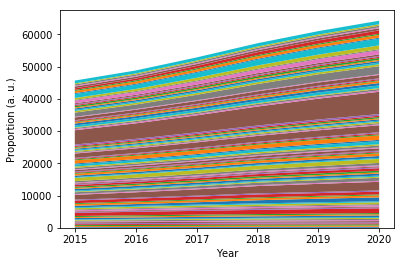

In [16]:
plt.stackplot(indexes.keys(), topics_weight)
plt.xlabel('Year')
plt.ylabel('Proportion (a. u.)')
plt.show()

Plot the change of the topics in **percents**.

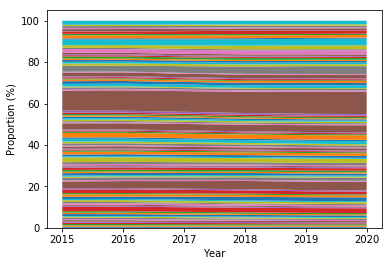

In [17]:
plt.stackplot(indexes.keys(), topics_weight_percent, labels = topic_names)
plt.xlabel('Year')
plt.ylabel('Proportion (%)')
plt.show()